In [44]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

solver = CloudPointSolver(
    model = [1, 100, 100, 100, 1],
    optimizer = "adam"
    )

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx + torch.pi * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 32
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 300

x_all = []
y_all = []

for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    pde_input = D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])

    ## define a bc
    bc_input = np.array([[t_span_start]])
    bc_output = np.array(1.).reshape([bc_epoch_size ,1])
    if T_id != 0:
        bc_output[0] = last_flame_data
    
    solver = CloudPointSolver(
        [[pde_input, pde_output],[bc_input, bc_output]],
        [pde_loss,data_loss],
        model = [1, 100, 100, 100, 1],
        optimizer = "adam",
        batchsize = [pde_batch_size,bc_batch_size])

    for epoch_local_id in range(epoch_per_iter):
        epoch_id = T_id * epoch_per_iter + epoch_local_id
        solver.train_step()
        if epoch_local_id % 100 == 0:
            solver.test_step(print_flag=True)

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver.model_eval(x_cpu)
    
    last_flame_data = solver.model_eval([[t_span_start + 2]]).item()
    print(last_flame_data)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])


loss is [5.1876187 0.8628726 6.0504913]
loss is [3.0801809e-01 2.9114672e-06 3.0802101e-01]
loss is [6.0966173e-03 1.1598726e-05 6.1082160e-03]
1.048733115196228
loss is [4.098903  0.1901945 4.289098 ]
loss is [2.1833720e+00 4.1008705e-05 2.1834130e+00]
loss is [5.0661406e-03 1.1260201e-05 5.0774007e-03]
1.049201488494873
loss is [4.465685  0.6815733 5.1472583]
loss is [4.3252301e+00 2.4737194e-05 4.3252549e+00]
loss is [2.9218788e+00 1.4631605e-03 2.9233420e+00]
0.8100560307502747


total error 0.16967714225701458
[[4.4656849e+00 6.8157327e-01 5.1472583e+00]
 [4.3252301e+00 2.4737194e-05 4.3252549e+00]
 [2.9218788e+00 1.4631605e-03 2.9233420e+00]]


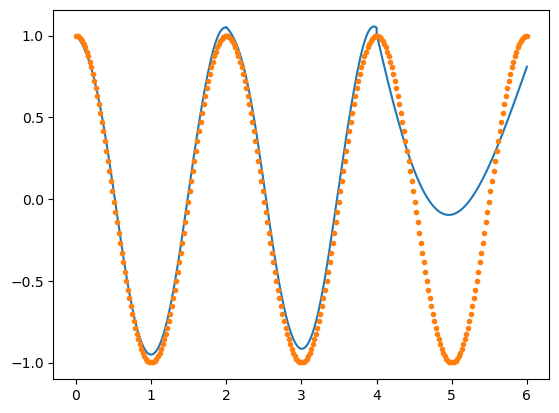

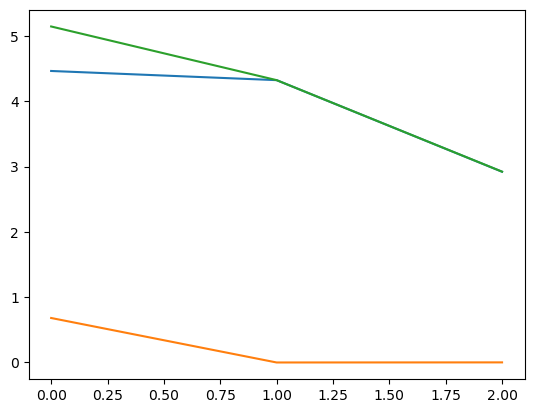

In [45]:

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )
test_log = solver.get_logger()
test_log_np = np.array(test_log)

fig,ax = plt.subplots()
plt.plot(test_log_np[:,0])
plt.plot(test_log_np[:,1])
plt.plot(test_log_np[:,2])
print(test_log_np)
